In [1]:
import os
import glob
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from numpy import mean, std
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data_dict = pd.read_pickle(r'data_dict.pkl')

In [3]:
df_shopping_pos = data_dict["shopping_pos"]

In [4]:
min(df_shopping_pos["Date"]), max(df_shopping_pos["Date"])

(datetime.date(2019, 1, 8), datetime.date(2022, 12, 25))

In [5]:
df_shopping_pos['Date'] = pd.to_datetime(df_shopping_pos['Date'], format='%Y-%m-%d')

In [6]:
# Set it as the index
df_shopping_pos.set_index('Date', inplace=True)
#df_shopping_pos = df_shopping_pos.asfreq('D')

In [7]:
df_shopping_pos.sample(5)

,Total Spend,Transaction Count,Average customer_merchant_distance_km
Date,,,
2022-11-04,823.79,2,87.801304
2021-05-03,2416.82,14,73.163775
2020-10-16,137256.69,1962,75.959145
2021-04-01,890.65,11,75.673853
2019-07-02,922.68,1,101.644834


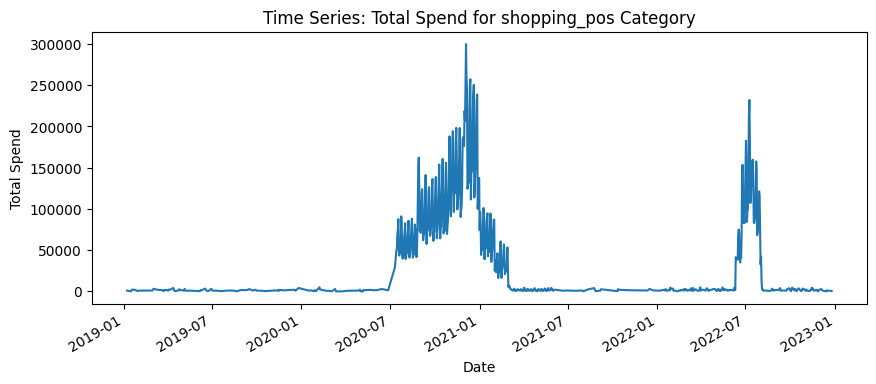

In [8]:
# Visualize the time series data
df_shopping_pos['Total Spend'].plot(figsize=(10, 4))
plt.xlabel('Date')
plt.ylabel('Total Spend')
plt.title('Time Series: Total Spend for shopping_pos Category')
plt.show()

### Check Stationarity

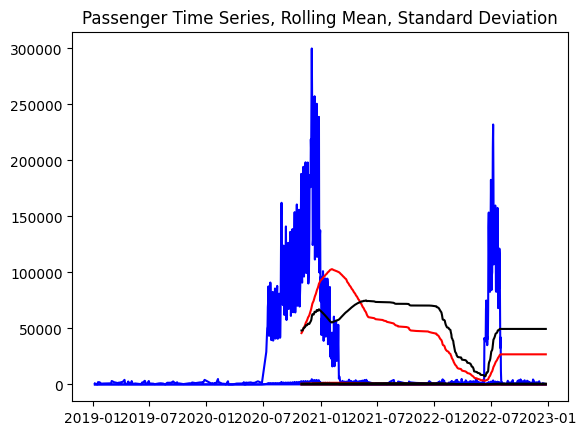

In [12]:
rolling_mean = df_shopping_pos.rolling(210).mean()
rolling_std = df_shopping_pos.rolling(210).std()


plt.plot(df_shopping_pos, color="blue",label="Original Passenger Data")
plt.plot(rolling_mean, color="red", label="Rolling Mean #Passenger")
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in #Passenger")
plt.title("Passenger Time Series, Rolling Mean, Standard Deviation")
plt.show()

In [16]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(df_shopping_pos["Total Spend"],autolag="AIC")
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -2.205792              Test Statistics
1    0.204150                      p-value
2   15.000000             No. of lags used
3  626.000000  Number of observations used
4   -3.440839          critical value (1%)
5   -2.866168          critical value (5%)
6   -2.569235         critical value (10%)


We can see that our data is not stationary from the fact that our p-value is greater than 5 percent and the test statistic is greater than the critical value. We can also draw these conclusions from inspecting the data, as we see a clear, increasing trend in the number of passengers.</br>
Source: https://builtin.com/data-science/time-series-python

### Autocorrelation

In [18]:
autocorrelation_lag1 = df_shopping_pos["Total Spend"].autocorr(lag=100)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df_shopping_pos["Total Spend"].autocorr(lag=200)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df_shopping_pos["Total Spend"].autocorr(lag=300)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df_shopping_pos["Total Spend"].autocorr(lag=400)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  -0.0021791666352117367
Three Month Lag:  -0.4947889121269564
Six Month Lag:  0.5186815908758716
Nine Month Lag:  0.23088645437913424


### Seasonal decompose

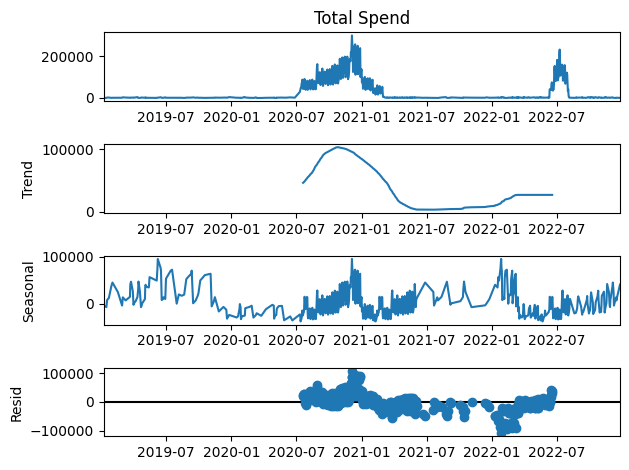

In [20]:
decompose = seasonal_decompose(df_shopping_pos["Total Spend"],model='additive', period=210)
decompose.plot()
plt.show()

/var/folders/9j/gbzf9fpd7_v0wb8s40h7d7n80000gn/T/ipykernel_56815/3190523759.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train["Total Spend"]
/var/folders/9j/gbzf9fpd7_v0wb8s40h7d7n80000gn/T/ipykernel_56815/3190523759.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test["Total Spend"]


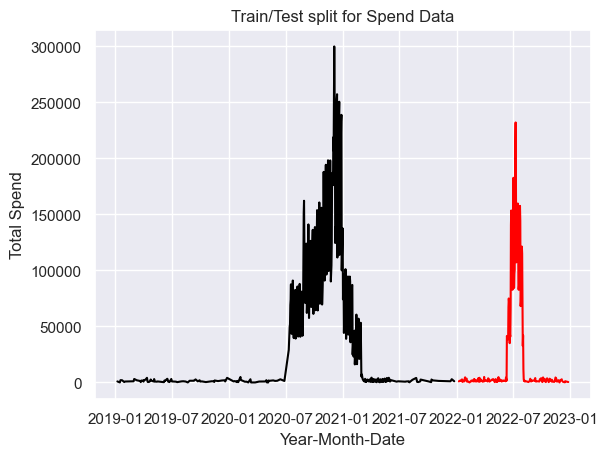

In [38]:
df = df_shopping_pos.drop(["Transaction Count", "Average customer_merchant_distance_km"], axis=1)
df['Date'] = df.index
train = df[df['Date'] < pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
train['train'] = train["Total Spend"]
del train['Date']
del train["Total Spend"]
test = df[df['Date'] >= pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
del test['Date']
test['test'] = test["Total Spend"]
del test["Total Spend"]
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Spend Data")
plt.ylabel("Total Spend")
plt.xlabel('Year-Month-Date')
sns.set()
plt.show()

In [39]:
train.sample()

,train
Date,
2021-01-28,68818.18


In [44]:
from pmdarima.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)
forecast = model.predict(n_periods=len(test))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9981.698, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10182.619, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10181.050, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10179.326, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10180.620, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10079.763, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9952.922, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10060.991, Time=0.04 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=10040.243, Time=0.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10072.498, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10072.888, Time=0.08 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=10034.091, Time=0.06 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=9950.665, Time=0.29 sec
 ARIMA(5,1,3)(0,0,0)[0] inte

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [48]:
forecast

445    2689.068146
446    2024.389741
447    1365.886741
448    1278.440945
449    1793.468443
          ...     
637    1627.658177
638    1701.462945
639    1749.124269
640    1718.275188
641    1796.214791
Length: 197, dtype: float64

In [63]:
fdf = pd.DataFrame({'Predictions': forecast, 'Date':test.index})

In [64]:
fdf

,Predictions,Date
445,2689.068146,2022-01-08
446,2024.389741,2022-01-09
447,1365.886741,2022-01-14
448,1278.440945,2022-01-16
449,1793.468443,2022-01-18
...,...,...
637,1627.658177,2022-12-08
638,1701.462945,2022-12-14
639,1749.124269,2022-12-15
640,1718.275188,2022-12-17


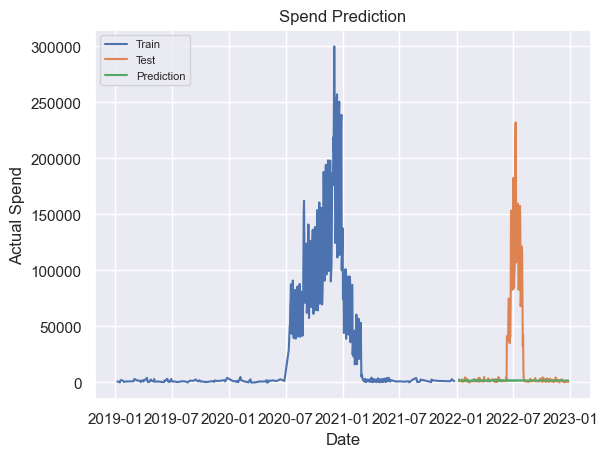

In [68]:
plt.plot(train.index, train["train"], label='Train')
plt.plot(test.index, test["test"], label='Test')
plt.plot(fdf["Date"], fdf["Predictions"], label='Prediction')
plt.title('Spend Prediction')
plt.xlabel('Date')
plt.ylabel('Actual Spend')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [60]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = mean_squared_error(test["test"], forecast)
print("RMSE: ", rms)

RMSE:  3281190385.198343


In [22]:
# Perform ARIMA modeling 
model = ARIMA(df_shopping_pos['Total Spend'], order=(1, 1, 1))
model_fit = model.fit()

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [12]:
# Forecast future values (example)
predictions = list()
output = model_fit.forecast()
#yhat = output[0]
predictions.append(output)

/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [16]:
output

642    561.948007
dtype: float64

In [ ]:
fig, ax = plt.subplots()
ax = df_shopping_pos.loc['2022':].plot(ax=ax)
plot_predict(model_fit, '2019', '2022', ax=ax)
plt.show()

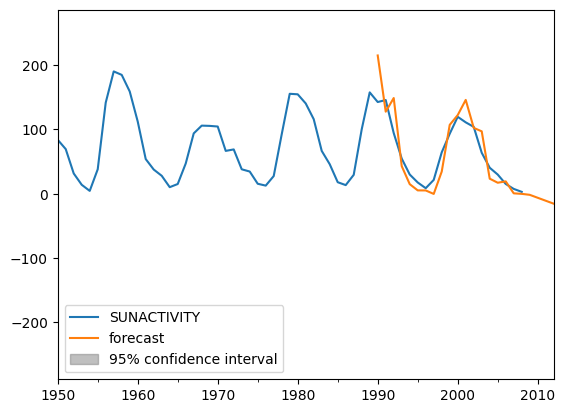

In [28]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
dta.index = pd.date_range(start='1700', end='2009', freq='A')
res = ARIMA(dta, order=(0,2,0)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1990', '2012', ax=ax)
plt.show()

In [29]:
dta.sample()

,SUNACTIVITY
1794-12-31,41.0
